# Fit regression models of seal abundance and presence
This notebook uses the information on the estimated number of seals per 5 x 5 KM grid cell to build regression models that aim to explain some of the factors that explain the observed distribution and abundance of Weddell seals around Antarctica.

Run this file every time you run the notebook "Attribute geospatial data with seal abundance data", as it means you have new geospatial covariates to analyze.

### Loading the required libraries and other dependencies

In [1]:
## Clear memory
rm(list=ls())
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,511879,27.4,940480,50.3,750400,40.1
Vcells,931863,7.2,1650153,12.6,1103576,8.5


In [2]:
libs<-c("ggplot2","plyr","dplyr","sp","rgeos","rgdal","raster","MASS","fitdistrplus","jsonlite")
lapply(libs, require, character.only = TRUE)
pathToLocalGit<-"/home/ubuntu/Workspace/ContinentalWESEestimates/"

## Load the source utility functions file
source(file=paste0(pathToLocalGit,"scripts/fitRegressionModels_functions.R"))

dataproj<-"+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0"

Loading required package: ggplot2

Loading required package: plyr

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: sp

Loading required package: rgeos

rgeos version: 0.5-2, (SVN revision 621)
 GEOS runtime version: 3.6.2-CAPI-1.10.2 
 Linking to sp version: 1.4-1 
 Polygon checking: TRUE 


Loading required package: rgdal

rgdal: version: 1.2-20, (SVN revision 725)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.2.3, released 2017/11/20
 Path to GDAL shared files: /usr/share/gdal/2.2
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]


[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

In [3]:
## load the WESE grid data
load(file=paste0(pathToLocalGit,"data/continentalWESE.RData"))
wesedf$fastIceRatio<-ifelse(is.na(wesedf$fastIceWidth),0,
                            ifelse(wesedf$fastIceWidth==0,0,wesedf$distNearestIceEdge/wesedf$fastIceWidth))
head(wesedf)
wesedf$ADPEname<-as.character(wesedf$ADPEname)
wesedf$EMPEname<-as.character(wesedf$EMPEname)
#removing the original abundances to use only the 2011, MLR approved values
wesedf<-wesedf[,which(!names(wesedf) %in% c("ADPEabund","EMPEabund"))]


,gridCellId,meanslope,meanbathy,glacierdist,distToShore,cont300dist,cont800dist,DecemberIcePresence,Persistence2Years,PredictabilityDec5Years,⋯,ADPEabund,EMPEname,EMPEdist,EMPEabund,coords.x1,coords.x2,mdlCol,mdlIsl,hasMaps,fastIceRatio
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,68791,2.621992,-2846.908,247849.6,201526.4,142791.6,588996.1,0,0,0,⋯,NA,NA,NA,NA,-2191000,2511000,0,0,0,0
2,68792,4.591249,-2587.330,250334.0,203621.5,142791.6,588996.1,0,0,0,⋯,NA,NA,NA,NA,-2186000,2511000,0,0,0,0
3,68819,1.411659,-3014.080,241050.2,194935.5,138016.9,584654.8,0,0,0,⋯,NA,NA,NA,NA,-2196000,2506000,0,0,0,0
4,68820,1.413779,-2920.630,243501.3,196973.9,138016.9,584654.8,0,0,0,⋯,NA,NA,NA,NA,-2191000,2506000,0,0,0,0
5,68821,4.561732,-2686.220,246029.6,199116.9,138016.9,584654.8,0,0,0,⋯,NA,NA,NA,NA,-2186000,2506000,0,0,0,0
6,68822,4.902608,-2264.930,248632.8,201361.3,138016.9,584654.8,0,0,0,⋯,NA,NA,NA,NA,-2181000,2506000,0,0,0,0


In [4]:
## Read the ADPE and EMPE colony size data from Michelle
adpedat<-read.csv(file=paste0(pathToLocalGit,"data/ADPE_colonies_20200416.csv"),stringsAsFactors=FALSE)
empedat<-read.csv(file=paste0(pathToLocalGit,"data/EMPE_colonies_20200327.csv"),stringsAsFactors=FALSE)

wesesp<-wesedf
names(wesesp)<-gsub("gridCellId","pointid",names(wesesp))
coordinates(wesesp)<-c("coords.x1","coords.x2")
proj4string(wesesp)<-CRS(dataproj)
## We want to rescale them by the decay function as discussed with Nadav and david
source("/home/ubuntu/fastIce/FastIceCovars/scripts/fastIceCovars_utils.R")
penguindf<-getDistanceToPenguins2011(studyarea_pointswLand=wesesp,adpedf=adpedat,empedf=empedat)
head(penguindf)

,pointid,ADPEname,ADPEdist,ADPEabund,EMPEname,EMPEdist,EMPEabund
,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,121905,Thule Island,1597981,0,Atka,110055.3,1623.017
2,121906,Thule Island,1602203,0,Atka,114386.0,1541.087
3,121907,Thule Island,1606429,0,Atka,118769.4,1802.988
4,121908,Thule Island,1610660,0,Atka,123199.7,1749.174
5,121909,Thule Island,1614895,0,Atka,127672.1,1698.200
6,121910,Kujira Point,1618768,0,Sanae,130802.4,1650.068


In [5]:
## Merge these penguin abundance data back to wesedf
names(penguindf)<-gsub("pointid","gridCellId",names(penguindf))
wesedf<-merge(wesedf,penguindf[,c("gridCellId","ADPEabund","EMPEabund")],by="gridCellId",all.x=TRUE)
wesedf$ADPEabund<-ifelse(is.na(wesedf$ADPEabund),0,wesedf$ADPEabund)
wesedf$EMPEabund<-ifelse(is.na(wesedf$EMPEabund),0,wesedf$EMPEabund)

In [6]:
## Some of the locatons with WESE have no penguin data
sum(wesedf$mdlCol>0 & is.na(wesedf$ADPEname))
sum(wesedf$mdlCol>0 & is.na(wesedf$EMPEname))
## These also have no fastIce, so we filter them out
nrow(wesedf)
wesedf<-subset(wesedf,(mdlCol==0) | (mdlCol>0 & fastIcePresent==TRUE))
nrow(wesedf)

[1] 37

[1] 37

[1] 227507

[1] 227470

In [7]:
# Too many cells with WESE have no bathymetry or slope data. 
# We use the mean bathymetry of cells with WESE for those those cells without bathymetry and with WESE
# We use the mean bathymetry of cells without WESE for those those cells without bathymetry and without WESE
sum(is.na(wesedf$meanbathy))
meanWbathy<-mean(subset(wesedf,mdlCol>0)$meanbathy,na.rm=T); meanNWbathy<-mean(subset(wesedf,mdlCol==0)$meanbathy,na.rm=T)
wesedf$meanbathy<-ifelse(!is.na(wesedf$meanbathy),wesedf$meanbathy,
                         ifelse(is.na(wesedf$meanbathy) & wesedf$mdlCol>0,meanWbathy,meanNWbathy))
sum(wesedf$meanbathy==meanWbathy) + sum(wesedf$meanbathy==meanNWbathy)

[1] 4087

[1] 4087

In [8]:
# We do the same mutatis mutandi for cells without slope
sum(is.na(wesedf$meanslope))
meanWslope<-mean(subset(wesedf,mdlCol>0)$meanslope,na.rm=T); meanNWslope<-mean(subset(wesedf,mdlCol==0)$meanslope,na.rm=T)
wesedf$meanslope<-ifelse(!is.na(wesedf$meanslope),wesedf$meanslope,
                         ifelse(is.na(wesedf$meanslope) & wesedf$mdlCol>0,meanWslope,meanNWslope))
sum(wesedf$meanslope==meanWslope) + sum(wesedf$meanslope==meanNWslope)

[1] 4360

[1] 4360

In [9]:
# There are 12 numeric variables in the data to be use for modeling, but 3 of these should be converted to factors
# One is DecemberIcePresence - since it is binary (0/1) there is no need to convert to a factor
wesedf$Persistence2Years<-as.numeric(as.character(wesedf$Persistence2Years))
wesedf$PredictabilityDec5Years<-as.numeric(as.character(wesedf$PredictabilityDec5Years))

# All other numeric variables need to be rescaled (except the ratio distEdge/width)
# Rescaling is so that values are bound between 0 and 14
wesedf$scaledmeanslope<-wesedf$meanslope/2
wesedf$logmeanbathy<--1*log(-1*wesedf$meanbathy) 
wesedf$logglacierdist<-log(wesedf$glacierdist+1) 
wesedf$logdistToShore<-log(wesedf$distToShore+1) 
wesedf$logcont300dist<-log(wesedf$cont300dist+1) 
wesedf$logcont800dist<-log(wesedf$cont800dist+1) 
wesedf$logdistNearestIceEdge<-log(wesedf$distNearestIceEdge+1)
wesedf$logfastIceWidth<-log(wesedf$fastIceWidth)
wesedf$logempedist<-log(wesedf$EMPEdist+1) 
wesedf$logadpedist<-log(wesedf$ADPEdist+1) 
wesedf$logADPEabund<-log(wesedf$ADPEabund+1)
wesedf$logEMPEabund<-log(wesedf$EMPEabund+1)


## Regresion analysis preliminaries

The above tble (wesedf) is ready for fitting regression models, but first we will need the following:
1. Be able to extend the attribution of the table with geospatial hypotheses (e.g., David's WESE zones vs. Michelle's WESE zones)
2. Generate N samples of "no-seal" locations of identical size as the number of grid cells with WESE presence
3. Be able to compute a linear model with the set of N bootstrap samples, and have it summarized for us
  
### On the above needs
__Regarding #1__ it is done with the functions "readShapeFile" and "attributeWithShape". The first function reads the shape file into a spatial object and the second one uses information on the spatial object (e.g., David's WESE zones) into the data.  
Here's an example to load a point shapefile, from an example copied into the repository's data folder:

OGR data source with driver: ESRI Shapefile 
Source: "/home/ubuntu/Workspace/ContinentalWESEestimates/data/Antarctic Regions_shapefile_20200528", layer: "Antarctic_Regions_WESE_v2"
with 4 features
It has 3 fields


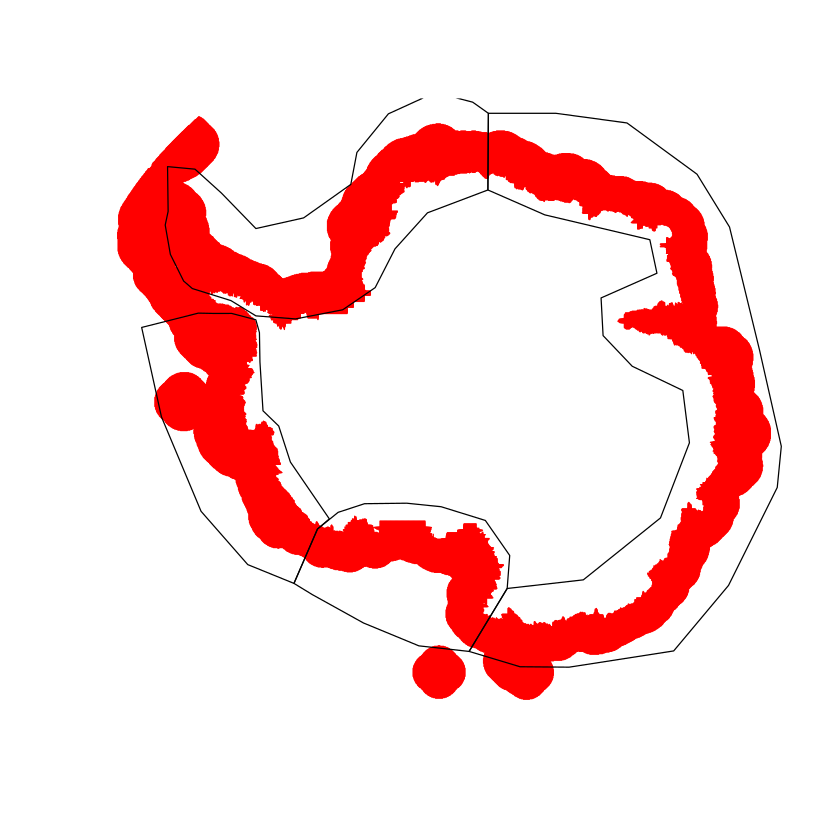

In [10]:
arWESE<-readShapeFile(pathToGit=pathToLocalGit,folderName="Antarctic Regions_shapefile_20200528",shapeName="Antarctic_Regions_WESE_v2")
proj4string(arWESE)<-CRS(dataproj)
#folderName is the folder name in the workspace, and shapeName is the name of the .shp file
wesespdf<-wesedf[,c("coords.x1","coords.x2")]
coordinates(wesespdf)<-c("coords.x1","coords.x2")
proj4string(wesespdf)<-CRS(dataproj)
plot(wesespdf,col="red")
plot(arWESE, add=T)


We could (but we don't because this is a point shapefile, not a polygon shapefile) use the spatial object "icebergs" ploted above to attribute wesedf with some information in it. We can see the contents of "icebergs" with a head:

In [11]:
head(arWESE)

,Id,Region,RegionNum
,<int>,<fct>,<int>
0,0,Ross Sea,1
1,0,Amundsen-Bellingshausen-WAP,2
2,0,Weddell Sea,3
3,0,East Antarctica,4


We should remove all areas without region attribution

So, we could attribute the wesedf table with the parameter "place_name", like so:

In [12]:
wesedf2<-attributeWithShape(shpobj=arWESE,attribName="Region",data=wesedf,datKey="gridCellId",
                              lonfld="coords.x1",latfld="coords.x2",dataproj=dataproj)

The example shapefileAntarcticRegions did not go far north enough to cover the entire fast ice region. We need to check and see if some of those grid cells missing region attribution had seals.

In [13]:
head(wesedf2)    #see the data
aa<-aggregate(gridCellId~Region,wesedf2,NROW)
    names(aa)<-c("Region","Num.Cells"); print(aa)    #count number of grid cells per region
sum(is.na(wesedf2$Region))    #How many grid cells without region attribution
sum(is.na(wesedf2$Region) & wesedf2$mdlCol>0)   #How many grid cells without a region yet with WESE?
sum(wesedf2$mdlCol>0 & wesedf2$fastIcePresent==TRUE)   #How many grid cells without a region yet with WESE?

,gridCellId,meanslope,meanbathy,glacierdist,distToShore,cont300dist,cont800dist,DecemberIcePresence,Persistence2Years,PredictabilityDec5Years,⋯,logdistToShore,logcont300dist,logcont800dist,logdistNearestIceEdge,logfastIceWidth,logempedist,logadpedist,logADPEabund,logEMPEabund,Region
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,68791,2.621992,-2846.908,247849.6,201526.4,142791.6,588996.1,0,0,0,⋯,12.21368,11.86915,13.28618,NA,NA,NA,NA,0,0,NA
2,68792,4.591249,-2587.330,250334.0,203621.5,142791.6,588996.1,0,0,0,⋯,12.22402,11.86915,13.28618,NA,NA,NA,NA,0,0,NA
3,68819,1.411659,-3014.080,241050.2,194935.5,138016.9,584654.8,0,0,0,⋯,12.18043,11.83514,13.27878,NA,NA,NA,NA,0,0,NA
4,68820,1.413779,-2920.630,243501.3,196973.9,138016.9,584654.8,0,0,0,⋯,12.19083,11.83514,13.27878,NA,NA,NA,NA,0,0,NA
5,68821,4.561732,-2686.220,246029.6,199116.9,138016.9,584654.8,0,0,0,⋯,12.20165,11.83514,13.27878,NA,NA,NA,NA,0,0,NA
6,68822,4.902608,-2264.930,248632.8,201361.3,138016.9,584654.8,0,0,0,⋯,12.21286,11.83514,13.27878,NA,NA,NA,NA,0,0,NA


                       Region Num.Cells
1 Amundsen-Bellingshausen-WAP     40897
2             East Antarctica     81198
3                    Ross Sea     23216
4                 Weddell Sea     50286


[1] 31873

[1] 0

[1] 1647

We can safely remove these grid points without region attribution, and grid points without fast ice. We lose 1647 seals in remote small islands...


In [14]:
wesedf2<-subset(wesedf2,!is.na(Region))
wesedf2<-subset(wesedf2,fastIcePresent==TRUE)

# Filtering for offshore small pockets
95% of all seals are found within 22 km from shore, as shown in the plot below.

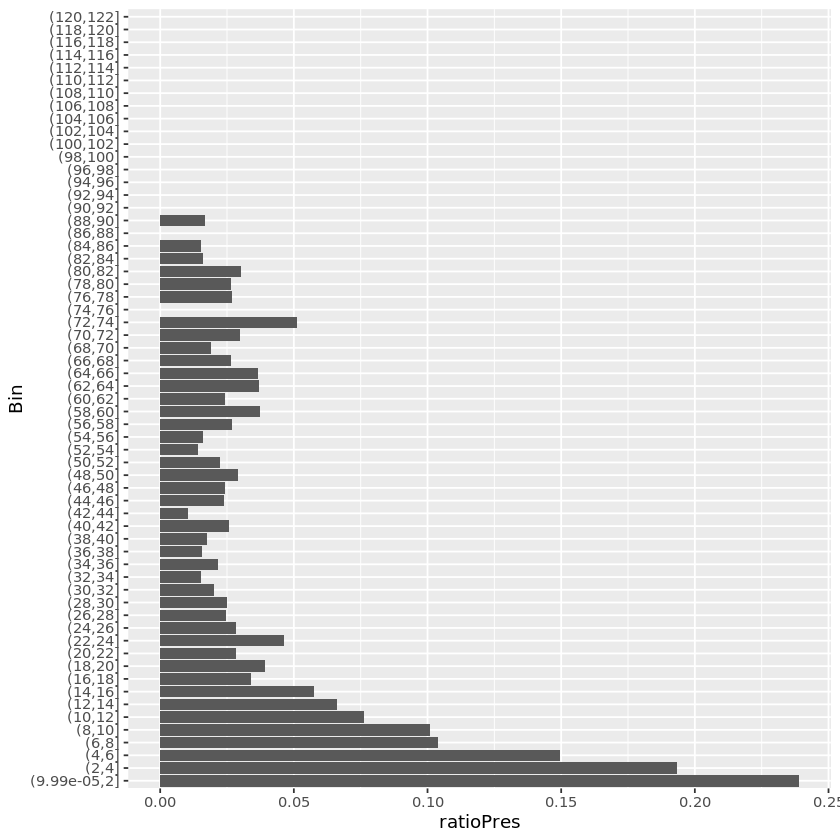

In [15]:
wesedf3<-wesedf2;wesedf3$presence<-ifelse(wesedf3$mdlCol>0,1,0)
brpres<-subset(wesedf3,presence==1)
qp<-table(cut(x=brpres$distToShore/1000,
        breaks=seq(min(wesedf3$distToShore/1000),max(wesedf3$distToShore/1000),by=2)))
brabs<-subset(wesedf3,presence==0)
qa<-table(cut(x=brabs$distToShore/1000,
        breaks=seq(min(wesedf3$distToShore/1000),max(wesedf3$distToShore/1000),by=2)))
brpdf<-as.data.frame(qp);names(brpdf)<-c("Bin","freqPres")
bradf<-as.data.frame(qa);names(bradf)<-c("Bin","freqAbs")
brdf<-merge(brpdf,bradf,by="Bin")
brdf$total<-brdf$freqPres+brdf$freqAbs
brdf$ratioPres<-ifelse(brdf$total==0,0,brdf$freqPres/brdf$total)
ggplot(brdf,aes(x=Bin,y=ratioPres)) + geom_bar(stat="identity") + coord_flip()


In [16]:
nrow(wesedf2)
wesedf2<-subset(wesedf2,distToShore <=22000)
save(wesedf2,file=paste0(pathToLocalGit,"data/dataForLeo.RData"))

[1] 19896

## Attributing with canyons and troughs data ##
We use the above function to attribute the data with the canyons and glacial troughs data from Jarrod Santora.  
IMPORTANT: we are adding Canyon_ID (i.e., the ID of the canyon), InCanyon (binary to say the grid cell is on a canyon), canyonLength, canyonWidth, and canyonMeanDepth. We are also adding gtID (i.e., the ID of the glacial through), InTrough (binary), and troughArea (the area of the glacial trough) for each grid cell that is on top of a trough. Cells not on trough or canyons get NA for the numeric values, and 0 for the InCanyon or InTrough fields.

In [17]:
canyons<-readShapeFile(pathToGit=pathToLocalGit,folderName="CanyonsTroughs",shapeName="Canyons")
troughs<-readShapeFile(pathToGit=pathToLocalGit,folderName="CanyonsTroughs",shapeName="Glacial_Trough")
troughs$gtID<-paste0("gtID_",1:nrow(troughs))

wesedf2<-attributeWithShape(shpobj=canyons,attribName="Canyon_ID",data=wesedf2,datKey="gridCellId",
                              lonfld="coords.x1",latfld="coords.x2",dataproj=dataproj)
wesedf2$InCanyon<-ifelse(is.na(wesedf2$Canyon_ID),0,1)
wesedf2<-attributeWithShape(shpobj=canyons,attribName="Length",data=wesedf2,datKey="gridCellId",
                              lonfld="coords.x1",latfld="coords.x2",dataproj=dataproj)
names(wesedf2)<-gsub("Length","canyonLength",names(wesedf2))
wesedf2<-attributeWithShape(shpobj=canyons,attribName="Width",data=wesedf2,datKey="gridCellId",
                              lonfld="coords.x1",latfld="coords.x2",dataproj=dataproj)
names(wesedf2)<-gsub("Width","canyonWidth",names(wesedf2))
wesedf2<-attributeWithShape(shpobj=canyons,attribName="Mean_Depth",data=wesedf2,datKey="gridCellId",
                              lonfld="coords.x1",latfld="coords.x2",dataproj=dataproj)
names(wesedf2)<-gsub("Mean_Depth","canyonMeanDepth",names(wesedf2))

wesedf2<-attributeWithShape(shpobj=troughs,attribName="gtID",data=wesedf2,datKey="gridCellId",
                              lonfld="coords.x1",latfld="coords.x2",dataproj=dataproj)
wesedf2$InTrough<-ifelse(is.na(wesedf2$gtID),0,1)
wesedf2<-attributeWithShape(shpobj=troughs,attribName="area_km2",data=wesedf2,datKey="gridCellId",
                              lonfld="coords.x1",latfld="coords.x2",dataproj=dataproj)
names(wesedf2)<-gsub("area_km2","troughArea",names(wesedf2))

#And then there is this silliness...
names(wesedf2)<-gsub("fastIcecanyonWidth","fastIceWidth",names(wesedf2))
names(wesedf2)<-gsub("scaledfastIcecanyonWidth","scaledfastIceWidth",names(wesedf2))

OGR data source with driver: ESRI Shapefile 
Source: "/home/ubuntu/Workspace/ContinentalWESEestimates/data/CanyonsTroughs", layer: "Canyons"
with 800 features
It has 11 fields
OGR data source with driver: ESRI Shapefile 
Source: "/home/ubuntu/Workspace/ContinentalWESEestimates/data/CanyonsTroughs", layer: "Glacial_Trough"
with 64 features
It has 3 fields


In [19]:
names(wesedf2)


[1] "gridCellId"              "meanslope"              
 [3] "meanbathy"               "glacierdist"            
 [5] "distToShore"             "cont300dist"            
 [7] "cont800dist"             "DecemberIcePresence"    
 [9] "Persistence2Years"       "PredictabilityDec5Years"
[11] "distNearestIceEdge"      "fastIceWidth"           
[13] "fastIcePresent"          "ADPEname"               
[15] "ADPEdist"                "EMPEname"               
[17] "EMPEdist"                "coords.x1"              
[19] "coords.x2"               "mdlCol"                 
[21] "mdlIsl"                  "hasMaps"                
[23] "fastIceRatio"            "ADPEabund"              
[25] "EMPEabund"               "scaledmeanslope"        
[27] "logmeanbathy"            "logglacierdist"         
[29] "logdistToShore"          "logcont300dist"         
[31] "logcont800dist"          "logdistNearestIceEdge"  
[33] "logfastIceWidth"         "logempedist"            
[35] "logadpedist"             "logADPEabund"           
[37] "logEMPEabund"            "Region"                 
[39] "Canyon_ID"               "InCanyon"               
[41] "canyonLength"            "canyonWidth"            
[43] "canyonMeanDepth"         "gtID"                   
[45] "InTrough"                "troughArea"

There are very many grid points without canyon or trough data.
## ONLY USE variables InCanyon and InThrough
All other data have too many missing values

# Export a copy of the data but only for the Weddell Sea

This is for Mia (DELETE WHEN DONE)

In [ ]:
weddellSeaData<-getWeddellSeaData(wesedf2)
nrow(weddellSeaData)
sum(weddellSeaData$presence>0)
save(weddellSeaData,file=paste0(pathToLocalGit,"data/weddellSeaData.RData"))

__Regarding #2__ we use the function "bootSampleWESEdata". This function by default generates 100 bootstrap samples (but change with the parameter "nsamples") and returns a list object. Each element of the list is one of the samples. Each sample is a table like wesedf, but it contains an equal number of grids with seals and no seals.  

We need this bootstrap to subsample among the cells with no seals, which are much more numerous than those with seals. 
  
The first distinction we must make is to determine if cells inspected in maps, but with no seals, are truly not seal habitat or simply areas with undetected seals. The wesedf table has a column called "hasMaps" to indicate cells with maps inspected by the crowd. The function "bootSampleWESEdata" can treat these as if they had no seals, or as if they did. You may indicate the behavior with the parameter "hasMapsBehavior". Set the parameter to 0 (this is the default behavior, what we consider is the right approach) to treat these cells as if there are no seals there, or 1 otherwise.

Additionally, we my want to stratify the sample by bins of the variables in wesedf. To do so, we use the parameter "strtifyByClusters". This parameter is a number between 2 and 5. The function will find clusters in the covariate space in the data, then assign each record to one of these clusters, and it will then stratify the random sample such that it includes an even number of values in each of the clusters.  

It is important to be able to select proper no-seal data points prior to clustering for sampling. Most critical is to select areas that are within a reasonable distance to shore (i.e., not to exceed the maximum observed). So, we first subsample the no-seal data within each region to exclude grid cells further away from shore than the farthest distance recorded for a colony in the region.

Lastly, the function can also return an ensemble of data converted to presence-absence. Again, if a grid with maps is considered to have seals (i.e., hasMapsBehavior=1), then it will be assigned presence = 1.

Here's an example on how to create an ensemble of abundance (no clustering, just normal random sampling):

In [20]:
# IF we want to stratify sampling by clusters, we'll need this
clustByVars<-c("scaledmeanslope","logmeanbathy","logglacierdist","logdistToShore","logcont300dist",
               "logcont800dist","logdistNearestIceEdge","logfastIceWidth","logempedist","logadpedist",
                "logADPEabund","logEMPEabund","Region","InCanyon","InTrough")

In [21]:
bootsamp<-bootSampleWESEdata(data=wesedf2,nsamples=100,hasMapsBehavior=0,stratifyByClusters=0,clustByVars=NA,countVar="mdlCol",setBinomial=TRUE)
head(bootsamp[[23]])
tail(bootsamp[[67]])
nrow(bootsamp[[85]])

,gridCellId,meanslope,meanbathy,glacierdist,distToShore,cont300dist,cont800dist,DecemberIcePresence,Persistence2Years,PredictabilityDec5Years,⋯,logEMPEabund,Region,Canyon_ID,InCanyon,canyonLength,canyonWidth,canyonMeanDepth,gtID,InTrough,troughArea
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,204675,4.2712026,-155.4118,6468.516,1365.2758,110835.58,21172.13,0,0,3,⋯,7.075504,Weddell Sea,NA,0,NA,NA,NA,NA,0,NA
2,627927,1.1131687,-194.6035,21737.037,746.8780,12361.87,115687.04,1,2,4,⋯,6.783017,East Antarctica,NA,0,NA,NA,NA,NA,0,NA
3,387963,0.3768610,-1119.2400,118261.237,2829.4935,54962.22,316786.66,1,2,5,⋯,0.000000,Weddell Sea,NA,0,NA,NA,NA,gtID_11,1,62460.806
4,316367,2.1936352,-289.0200,15661.026,750.1401,123278.70,62575.49,1,1,4,⋯,2.448570,East Antarctica,NA,0,NA,NA,NA,NA,0,NA
5,1236693,0.3701106,-211.7300,20579.326,5402.8569,1171996.08,1130686.02,1,1,5,⋯,0.000000,East Antarctica,NA,0,NA,NA,NA,gtID_22,1,3196.236
6,535874,2.4104955,-359.2100,73535.938,5508.1817,90820.40,42321.16,1,0,4,⋯,7.157579,Amundsen-Bellingshausen-WAP,NA,0,NA,NA,NA,NA,0,NA


,gridCellId,meanslope,meanbathy,glacierdist,distToShore,cont300dist,cont800dist,DecemberIcePresence,Persistence2Years,PredictabilityDec5Years,⋯,logEMPEabund,Region,Canyon_ID,InCanyon,canyonLength,canyonWidth,canyonMeanDepth,gtID,InTrough,troughArea
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
11693,1264355,0.3815142,-403.40,34786.34,2868.045,1018372,970261.5,1,1,5,⋯,9.385815,East Antarctica,NA,0,NA,NA,NA,NA,0,NA
11719,1264733,0.7591642,-247.11,28629.81,4546.889,1029342,981803.6,1,2,5,⋯,8.612284,East Antarctica,NA,0,NA,NA,NA,NA,0,NA
11720,1264734,0.8076776,-307.09,33628.94,3474.870,1029342,981803.6,1,2,5,⋯,8.679836,East Antarctica,NA,0,NA,NA,NA,gtID_58,1,13812.46
11735,1264861,0.7865700,-303.30,28963.48,8938.282,1033021,985671.7,1,2,5,⋯,8.568686,East Antarctica,NA,0,NA,NA,NA,gtID_58,1,13812.46
11736,1264862,0.5470907,-330.04,33913.46,8299.567,1033021,985671.7,1,2,5,⋯,8.627028,East Antarctica,NA,0,NA,NA,NA,gtID_58,1,13812.46
11752,1264989,0.5477518,-359.48,30134.71,13663.857,1036711,989550.0,1,2,5,⋯,8.520304,East Antarctica,NA,0,NA,NA,NA,gtID_58,1,13812.46


[1] 2924

__Regarding #3__ we use the function "fitModelToBootstrap" to fit a simple or generalized regression model to the full ensemble. The function just requires a formula, the ensemble as generated above, and the error family link (by default the Gaussian, which is a normal error).  
  
The default behavior (i.e., Gaussian error) fits a normal linear model. Otherwise, use "poisson" if you think it is appropriate for the counts, or "binomial" if fitting logistic regressions (that is, if you set the setBinomial parameter to TRUE when generating the ensemble above). In the case of poisson or logistic regression, a generalized linear model is fit. We can add a negative binomial option later, to accommodate for overdispersion. But for now let's start working with this to get it going.  
  
Whether fitting a simple regression or a generalized liner model, the output is the same, with the exception that R-squared values cannot be obtained from a GLM. Instead, the function returns the residual deviance of the model for each sample bootstrap.  
  
The function returns a list with 3 objects: coefficients, goodness-of-fit data, and residuals. But because it performs the model fit on an ensemble of data, it returns a collection of results within each of the above objects.  
  
For example, the coefficients object is actually 4 data.frames. Each data.frame has as many columns as datasets in the ensemble (from the example above, 100 columns), and each row in the data.frame is a different coefficient from the model. The four data.frames are, respectively: the coefficient estimates, their standard errors, t-values and p-values.  
  
The residuals data is a single data.frame: each row is a datum in the ensemble, each column is the set of residuals for each model fit. Since every bootstrap sample has 3368 records, this data.frame would have 3368 rows and 100 columns.
  
The GOF data is also only one data.frame. But unlike the other results above, each column is a GOF paramter, and each row is a different ensemble result. So, it has 4 columns: the degees of freedom of the model, the AIC of the model, the -2*logLikelyhood of the model, and the R-squared or residual deviance. Therefore, for example, with the above bootstrap ensemble the function would return a data.frame of 4 columns, and 100 rows.  
  
Let's try it.

# Michelle, start here
...trying to fit abundance models

### Here are the covariates you can use.
Think of using linear and quadratic forms for the numerics, and combinations between numerics and factors. Remember that quadratics must be added to the equation as so: I(distToShore^2). You must put it in parentheses with the "I" at the beginning. Each factor you use will generate as many coefficients as levels in the factor minus 1. For example, Persistence2Years has 3 levels, so adding it to the model will result in 2 coefficients fit. Combining numerics and factors means a slope of the numeric for each level of the factor.   
   
Numeric:   
  * scaledmeanslope   
  * logmeanbathy  
  * logglacierdist  
  * logdistToShore  
  * logcont300dist  
  * logcont800dist  
  * logdistNearestIceEdge  
  * logfastIceWidth  
  * logempedist  
  * logadpedist  
  * logADPEabund  
  * logEMPEabund  
  * fastIceRatio  
  * Persistence2Years (3 levels: 0, 1, 2)  
  * PredictabilityDec5Years (6 levels: 0, 1,...,5)
  
Factors:  
  * DecemberIcePresence (0/1)    
  * InCanyon (0/1)  
  * InTrough (0/1)  
  * Region  

In [22]:
fml<-paste0("presence~scaledmeanslope+I(scaledmeanslope^2)+logmeanbathy+",
            "logdistToShore+logcont800dist+InCanyon+",
            "logempedist+I(logempedist^2)+logadpedist+I(logadpedist^2)+",
            "Persistence2Years*Region+Region*fastIceRatio")
reslst<-fitModelToBootstrap(fml=fml,datalist=bootsamp,fam="binomial")
## Note: not indicating the family so it defaults to "gaussian" and fits a simple regression

In [23]:
gofres<-summarizeResults(fitobj=reslst,what="gof")
print(gofres)

                  Parameter     Value Nboot
Df                       Df  2902.000   100
AIC                     AIC  3145.746   100
LogLik               LogLik -1550.873   100
ResidDeviance ResidDeviance  3101.746   100


Let's examine the results, starting with a summary of the coefficients. For this we use the function "summarizeResults". The function has two arguments: the fitobj is the object resulting from using the fitModelToBootstrap function above (in our example, fitobj is reslst), and the "what" parameter. This parameter has three possible values: "coefs", "gof", or "resids". The latter is the vector of average residuals. Let's look at the coefficients and the goodness-of-fit results.

In [24]:
coefres<-summarizeResults(fitobj=reslst,what="coefs")
row.names(coefres)<-NULL
print(coefres)

                                 Parameter Coefficient StError t_value Prob_t
1                              (Intercept)      32.600   4.275   7.602  0.000
2                          scaledmeanslope       0.371   0.140   2.637  0.030
3                     I(scaledmeanslope^2)      -0.079   0.032  -2.451  0.030
4                             logmeanbathy       0.224   0.059   3.769  0.003
5                           logdistToShore       0.821   0.054  15.234  0.000
6                           logcont800dist      -0.099   0.040  -2.460  0.039
7                                 InCanyon      -2.034   0.678  -3.014  0.007
8                              logempedist      -5.137   0.700  -7.311  0.000
9                         I(logempedist^2)       0.224   0.032   6.911  0.000
10                             logadpedist      -0.942   0.330  -2.840  0.023
11                        I(logadpedist^2)       0.038   0.015   2.549  0.041
12                       Persistence2Years      -0.682   0.187  

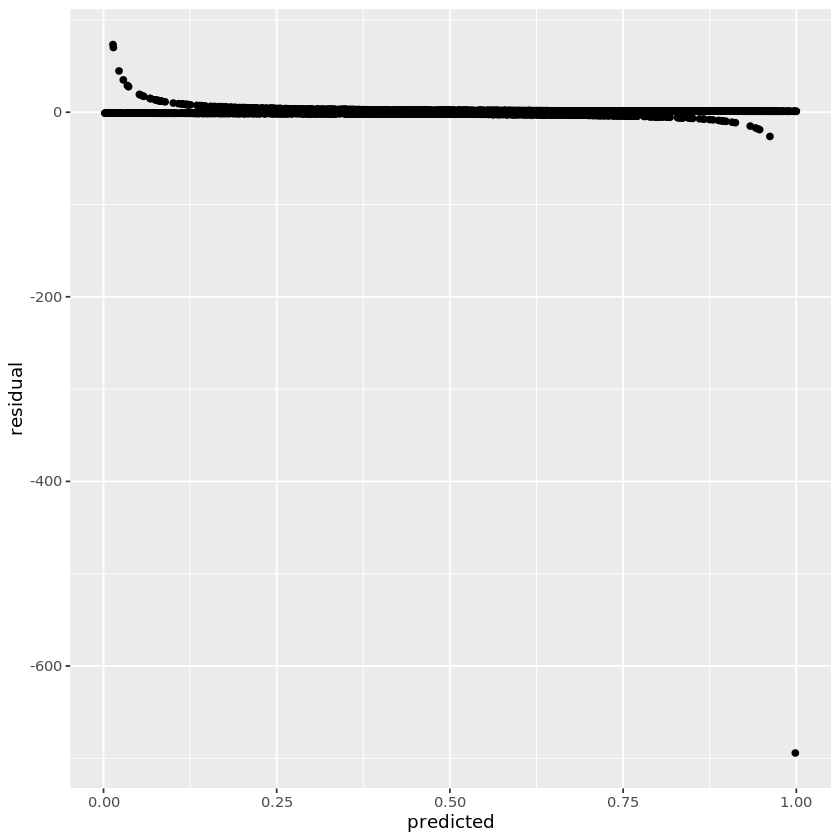

In [25]:
rdf<-summarizeResults(fitobj=reslst,what="residplot")
p<-ggplot(subset(rdf,bootstrap==54),aes(x=predicted,y=residual)) + geom_point()
print(p)

The above should be evenly distributed around the 0 value in the y-axis. We have an outlier!

# Or try a single bootstrap sample using presence/absence first
We can try abundance later.

In [ ]:
dt<-bootsamp[[78]]
dt$presence<-ifelse(dt$abundance==0,0,1)
aggregate(gridCellId~Region+presence,dt,NROW)
fml<-paste0("presence~Persistence2Years+PredictabilityDec5Years+InTrough*scaledmeanslope+",
            "I(scaledmeanslope^2)+scaledmeanbathy+I(scaledmeanbathy^2)+scaledcont800dist+",
            "I(scaledcont800dist^2)+scaledcont300dist+I(scaledcont300dist^2)+",
            "scaleddistToShore+I(scaleddistToShore^2)+scaledempedist+I(scaledempedist^2)+",
            "scaledadpedist+I(scaledadpedist^2)+scaledadpedist*logADPEabund+scaledempedist*logEMPEabund")
mdl<-glm(formula=fml,data=dt,family="binomial")
summary(mdl)
layout(matrix(c(1,2,3,4),2,2)) 
plot(mdl)
paste("AIC:",AIC(mdl))

In [ ]:
dt<-bootsamp[[91]]
dt$presence<-ifelse(dt$abundance==0,0,1)
aggregate(gridCellId~Region+presence,dt,NROW)
fml<-paste0("presence~Persistence2Years+PredictabilityDec5Years+InTrough*scaledmeanslope+",
            "I(scaledmeanslope^2)+I(scaledmeanbathy^2)+scaledmeanbathy+scaledcont800dist+",
            "I(scaledcont800dist^2)+scaledcont300dist+I(scaledcont300dist^2)+scaledfastIceWidth+fastIceRatio+",
            "I(scaledfastIceWidth^2)+scaleddistToShore+I(scaleddistToShore^2)+scaledempedist+I(scaledempedist^2)+",
            "scaledadpedist+I(scaledadpedist^2)+scaledadpedist*logADPEabund+scaledempedist*logEMPEabund")
mdl<-glm(formula=fml,data=dt,family="binomial")
summary(mdl)
layout(matrix(c(1,2,3,4),2,2)) 
plot(mdl)
paste("AIC:",AIC(mdl))